# Loading the Data

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# First, we get the data
dataset = pd.read_csv('AMZN_2006-01-01_to_2018-01-01.csv', index_col='Date',
parse_dates=['Date'])
dataset.head()

Instructions for updating:
non-resource variables are not supported in the long term


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


# Splitting the Data

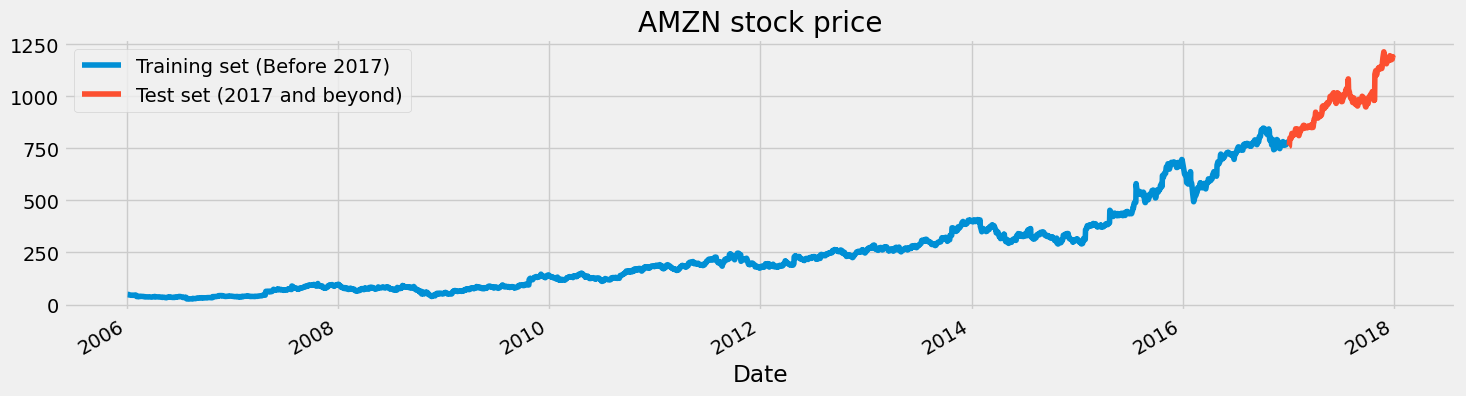

In [2]:

# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('AMZN stock price')
plt.show()

# Preprocessing the Data

In [3]:
# **Data Augmentation**
# Introduce some synthetic variations by applying minor random shifts
augmented_training_set = training_set + np.random.normal(0, 0.01, training_set.shape)
training_set_combined = np.vstack((training_set, augmented_training_set))


In [4]:
# Normalization: Scale the combined training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set_combined)
test_set_scaled = sc.transform(test_set)  # Apply the same scaler to test set

In [5]:
# Resizing: LSTM input requires reshaping with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [6]:
# Reshaping X_train for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(f"Shape of X_train: {X_train.shape}")

Shape of X_train: (5476, 60, 1)


# Converting Inputs for RNN

In [7]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)

(2708, 60, 1)


# RNN Model

In [8]:
# Updated LSTM architecture with 4 LSTM layers and 1 output layer 
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))  # Dropout to prevent overfitting

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# Output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Fitting to the training set
history = regressor.fit(X_train, y_train, epochs=50, batch_size=32)


Train on 2708 samples
Epoch 1/50
2708/2708 [==============================] - 4s 2ms/sample - loss: 0.0080
Epoch 2/50
2708/2708 [==============================] - 4s 1ms/sample - loss: 0.0020
Epoch 3/50
2708/2708 [==============================] - 4s 1ms/sample - loss: 0.0020
Epoch 4/50
2708/2708 [==============================] - 4s 1ms/sample - loss: 0.0019
Epoch 5/50
2708/2708 [==============================] - 4s 1ms/sample - loss: 0.0018
Epoch 6/50
2708/2708 [==============================] - 4s 1ms/sample - loss: 0.0017
Epoch 7/50
2708/2708 [==============================] - 4s 1ms/sample - loss: 0.0018
Epoch 8/50
2708/2708 [==============================] - 4s 1ms/sample - loss: 0.0016
Epoch 9/50
2708/2708 [==============================] - 4s 1ms/sample - loss: 0.0016
Epoch 10/50
2708/2708 [==============================] - 4s 1ms/sample - loss: 0.0011
Epoch 11/50
2708/2708 [==============================] - 4s 1ms/sample - loss: 0.0012
Epoch 12/50
2708/2708 [==================

# Preparing Data for Testing

In [9]:
# Prepare test inputs for prediction
dataset_total = pd.concat((dataset["High"][:'2016'], dataset["High"]['2017':]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs_scaled = sc.transform(inputs)

X_test = []
for i in range(60, inputs_scaled.shape[0]):
    X_test.append(inputs_scaled[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict stock prices
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Evalutation and Testing

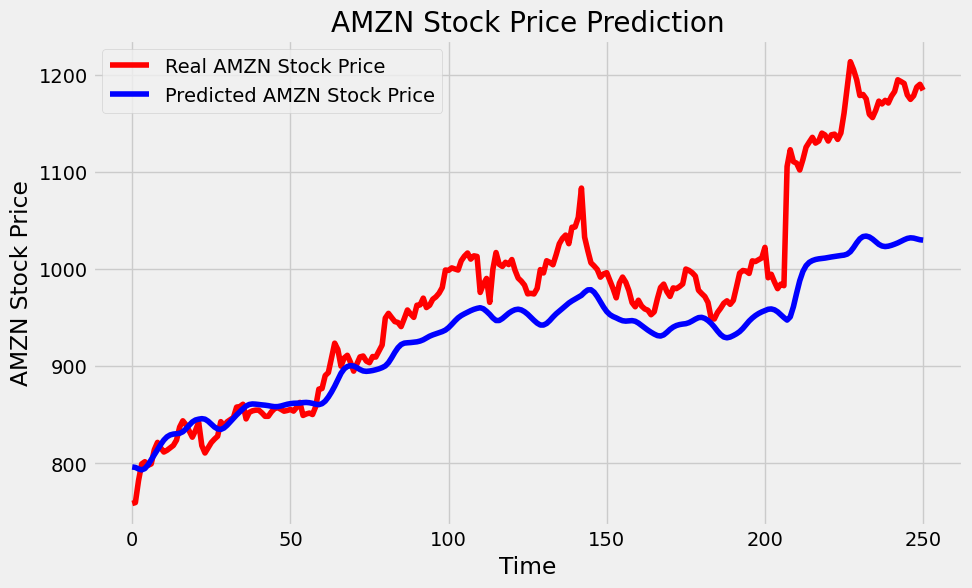

The root mean squared error is 69.05.


In [10]:
# Visualization and Evaluation
def plot_predictions(test, predicted):
    plt.figure(figsize=(10, 6))
    plt.plot(test, color='red', label='Real AMZN Stock Price')
    plt.plot(predicted, color='blue', label='Predicted AMZN Stock Price')
    plt.title('AMZN Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('AMZN Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print(f"The root mean squared error is {rmse:.2f}.")

plot_predictions(test_set, predicted_stock_price)
return_rmse(test_set, predicted_stock_price)

The root mean squared error is 69.05.


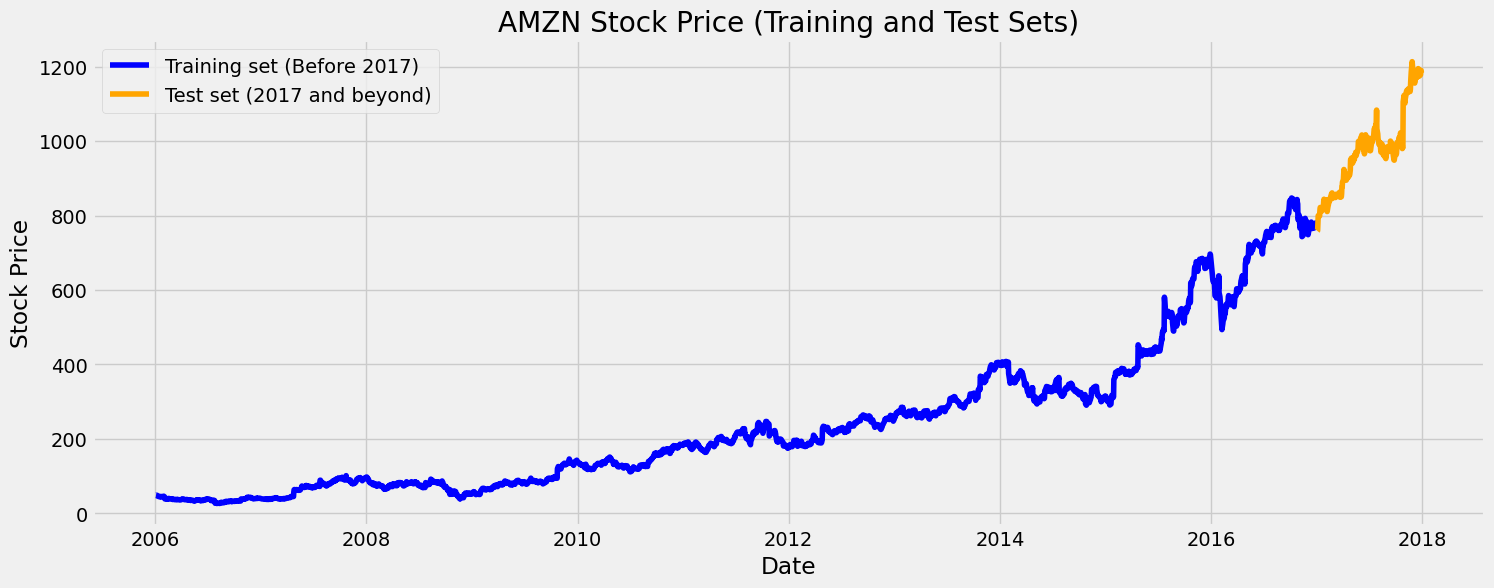

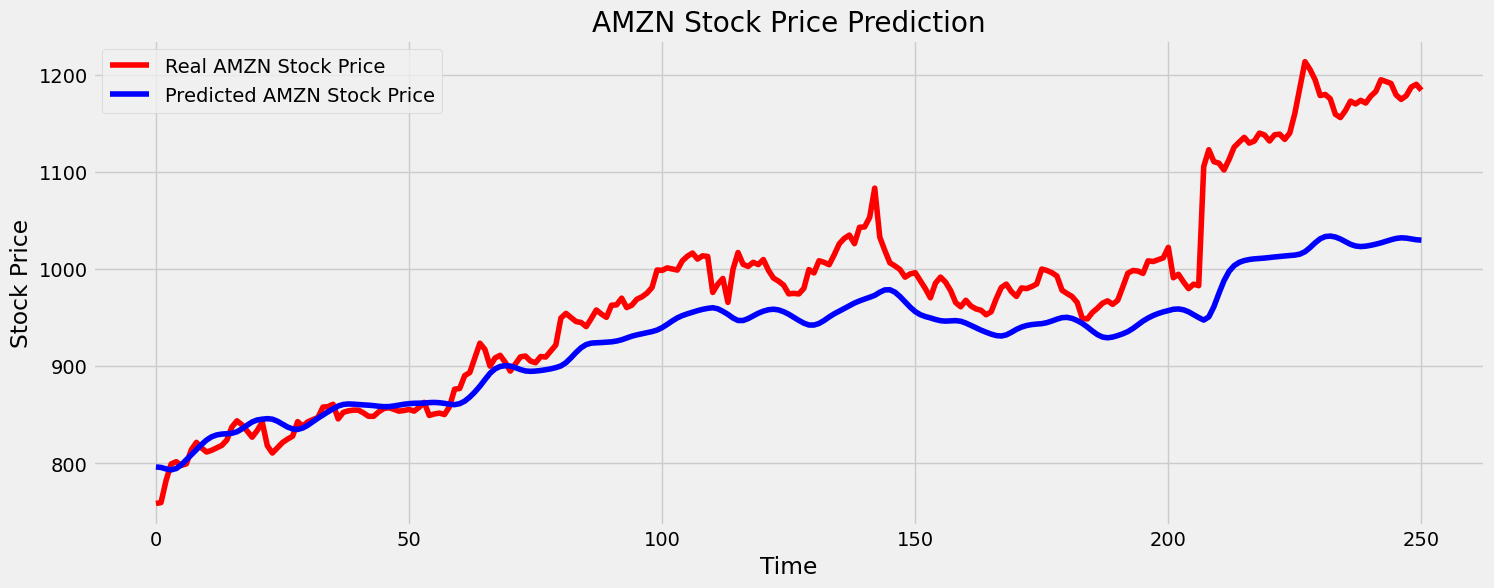

In [11]:
# Evaluate the model
return_rmse(test_set, predicted_stock_price)

# Visualizing training and test data
plt.figure(figsize=(16, 6))

# Training and test set visualization
plt.plot(dataset["High"][:'2016'], label='Training set (Before 2017)', color='blue')
plt.plot(dataset["High"]['2017':], label='Test set (2017 and beyond)', color='orange')
plt.title('AMZN Stock Price (Training and Test Sets)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Visualizing Real vs. Predicted Prices
plt.figure(figsize=(16, 6))

# Plot actual vs predicted stock prices
plt.plot(test_set, color='red', label='Real AMZN Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted AMZN Stock Price')
plt.title('AMZN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# OTHER VISUALIZATIONS

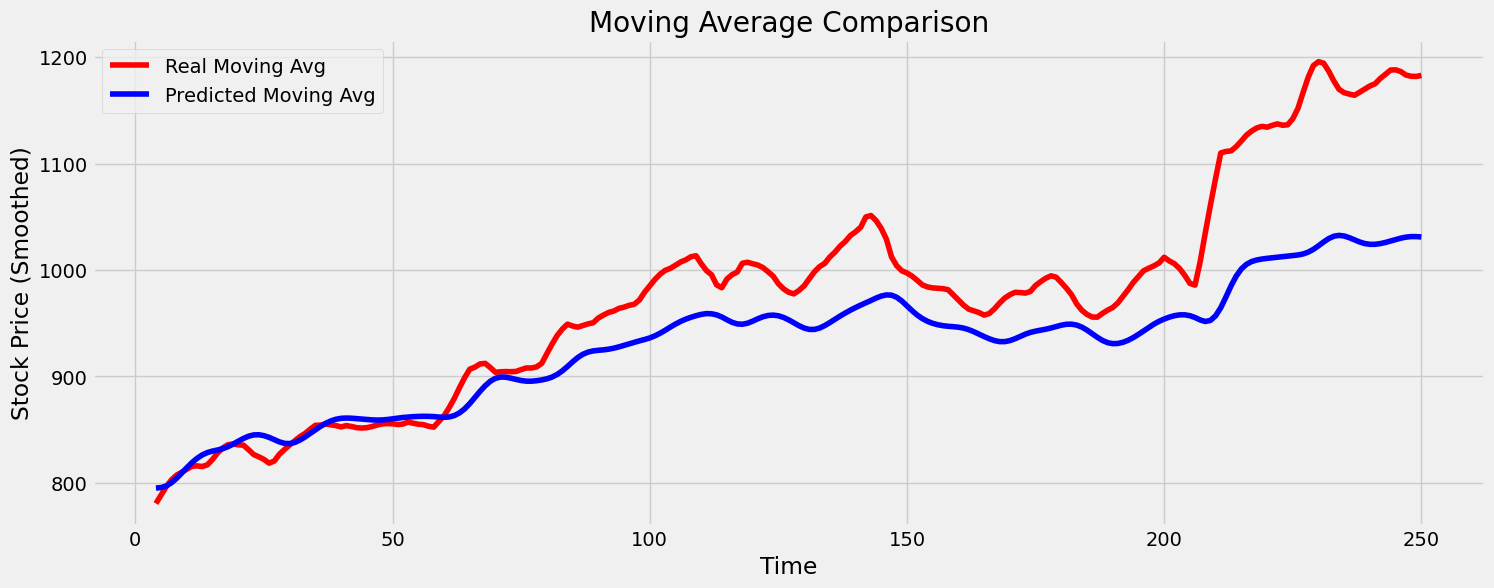

In [12]:
# Compute moving averages (window=5 for smoothing)
real_moving_avg = pd.Series(test_set.flatten()).rolling(window=5).mean()
predicted_moving_avg = pd.Series(predicted_stock_price.flatten()).rolling(window=5).mean()

plt.figure(figsize=(16, 6))
plt.plot(real_moving_avg, label='Real Moving Avg', color='red')
plt.plot(predicted_moving_avg, label='Predicted Moving Avg', color='blue')
plt.title('Moving Average Comparison')
plt.xlabel('Time')
plt.ylabel('Stock Price (Smoothed)')
plt.legend()
plt.show()

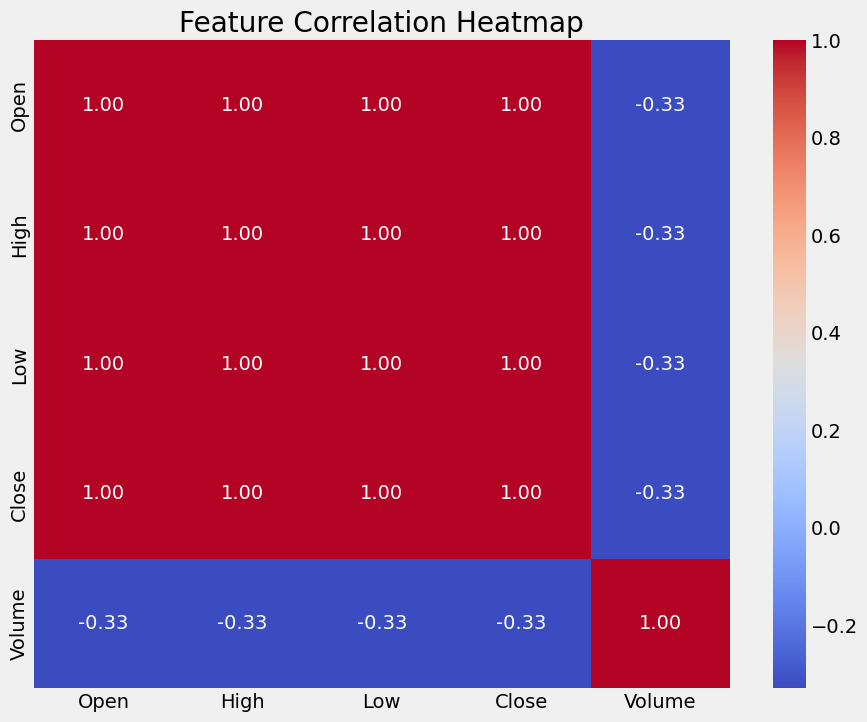

In [13]:
# Compute correlation matrix for numeric columns only
numeric_dataset = dataset.select_dtypes(include=[np.number])
corr_matrix = numeric_dataset.corr()

# Heatmap visualization
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

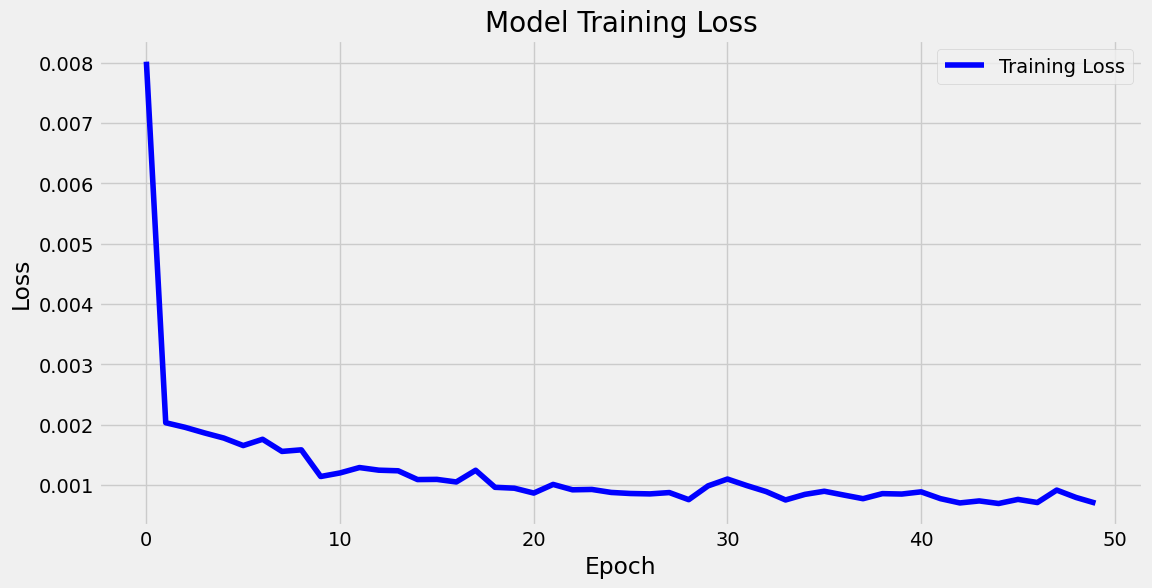

In [14]:
# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()